In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2gray
import cv2
from scipy.ndimage.morphology import binary_fill_holes
from skimage.morphology import binary_opening, binary_closing, binary_erosion
from skimage import measure
from skimage.segmentation import watershed
from skimage.color import label2rgb
from skimage.feature import canny
from skimage.filters import sobel, threshold_local
from math import atan, pi, sqrt

В первую очередь необходимо обнаружить на изображении метки. Воспльзуемся для этого фильтрацией по цвету, т.к. метки синего цвета.

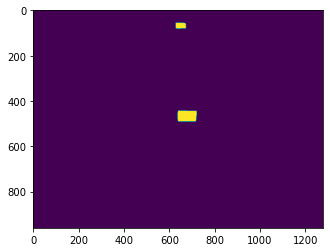

In [2]:
img = cv2.imread('data/1.jpg')

BLUE_MIN = np.array([108, 65, 65],np.uint8) # Значение границ синего в 
BLUE_MAX = np.array([125, 255, 255],np.uint8) # цветовой гамме HSV

hsv_img = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)

frame_threshed = cv2.inRange(hsv_img, BLUE_MIN, BLUE_MAX)

mask = binary_opening(frame_threshed, selem=np.ones((18, 21))) # Удаляем шумы
plt.imshow(mask)

Далее из меток получим информацию о том, как близко находится стул к столу и о том, какими координатами обладает метка, находящаяся на стуле.

In [3]:
NEAR_ATTITIDE = 3.5 # Отношение площадей меток в случае, когда стул рядом со столом
TAGS_NUMBER = 2

def find_rect_square(contour): # Нахождение площади по контуру
    cont_x = [i for _, i in contour]
    cont_y = [j for j, _ in contour]
        
    weidth = max(cont_x) - min(cont_x)
    
    height = max(cont_y) - min(cont_y)
    
    return weidth * height

def find_midl_coords(contour): # Нахождение координат и размеров метки по контуру
    cont_x = [i for _, i in contour]
    cont_y = [j for j, _ in contour]
    
    x = (max(cont_x), min(cont_x))
    y = (max(cont_y), min(cont_y))
    weidth = x[0] - x[1]
    height = y[0] - y[1]
    return (int((x[0] + x[1])/2), int((y[0] + y[1])/2), weidth, height)

contours = measure.find_contours(mask)
if len(contours) == TAGS_NUMBER:
    m_1 = find_rect_square(contours[0])
    m_2 = find_rect_square(contours[1])
    attitude = ((m_2/m_1) / NEAR_ATTITIDE)**0.5
    
    point_x, point_y, weidth, height = find_midl_coords(contours[1])
    
    print(attitude)
else:
    print("Метки не найдены")

0.9981668178901743


Если мы нашли метки, то двигаемся дальше. Следующим шагом найдем ширину и высоту стола. Для этого воспользуемся грубым фильтром по цвету и найдем высоту. А дальше воспользуемся фильтром canny и sobel, для нахождения границ объектов на изображении и оттуда найдем ширину стола.

1280
482


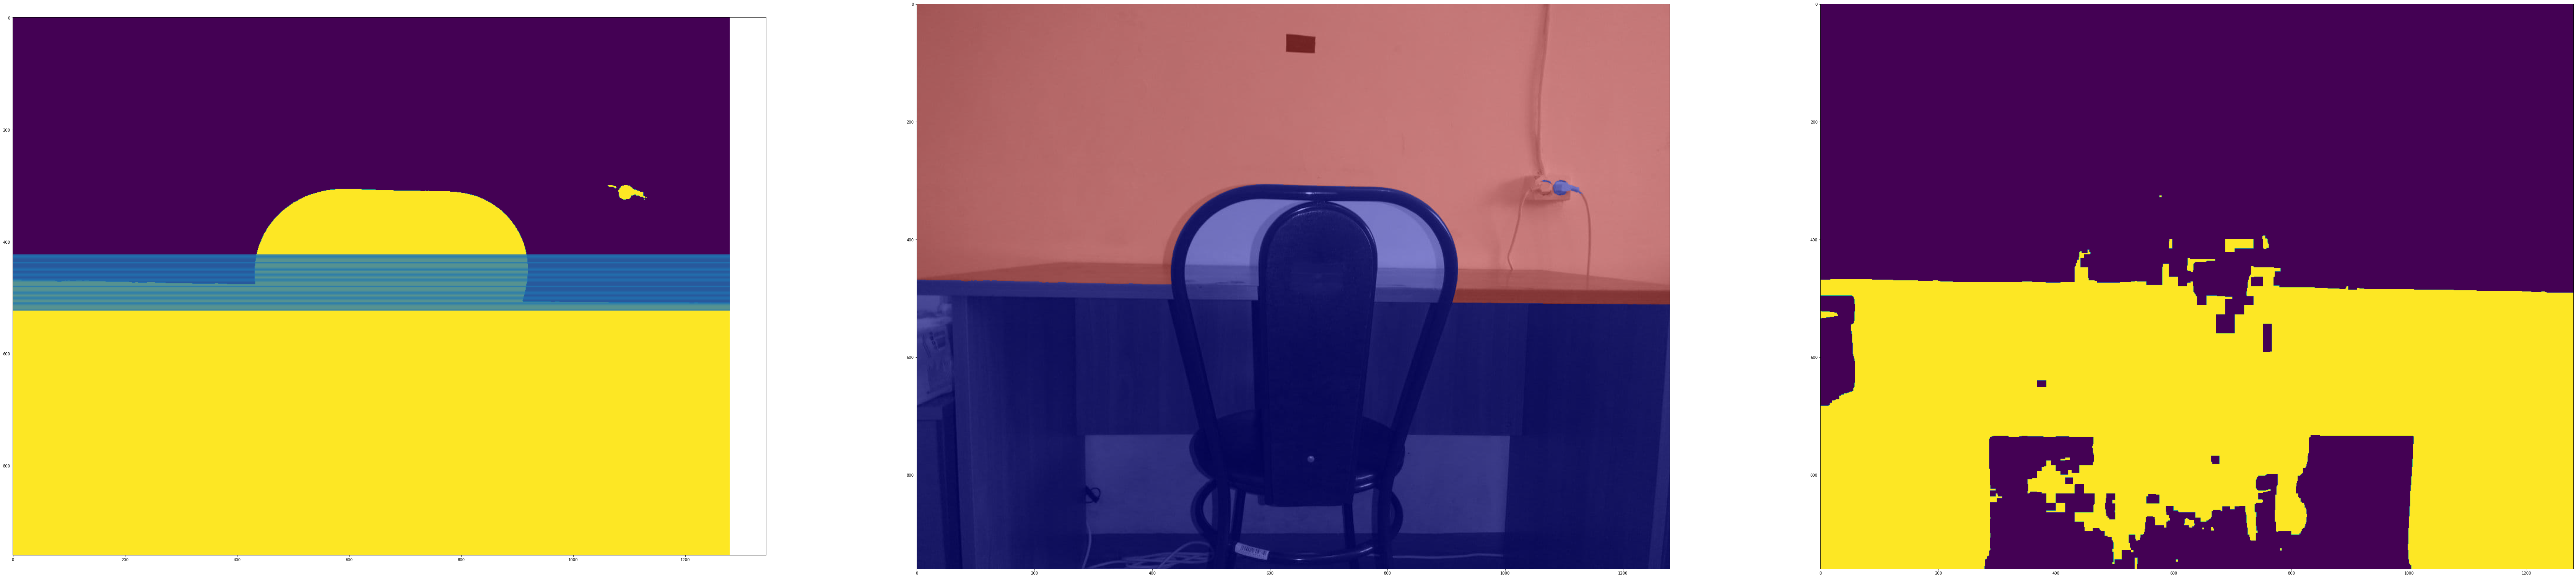

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(120, 60))

matchimg = rgb2gray(img) # детекторы границ по умолчанию работают с одним каналом

TABLE_MIN = np.array([0, 100, 0]) # HSV значения для грубого нахождения 
TABLE_MAX = np.array([20, 220, 200]) # стола

hsv_img = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)

frame_threshed = cv2.inRange(hsv_img, TABLE_MIN, TABLE_MAX)
mask = binary_opening(frame_threshed, selem=np.ones((3, 3)))
mask = binary_closing(mask, selem=np.ones((10, 10)))

# Найдем высоту стола, как максимальную высоту на маске
table_height = 0 
i_max = 0
for j in range(len(mask[0])):
    counter = 0
    for i in range(len(mask)):
        if mask[i][j]:
            counter += 1
        else:
            if table_height < counter:
                table_height = counter
                i_max = i
            counter = 0

table_weight = 0

canny_edge_map = binary_closing(canny(matchimg, sigma=2.5), selem=np.ones((4, 4)))

# поставим маркеры фона и объекта
markers = np.zeros_like(matchimg)
markers[0:10, 0:10] = 1 # маркеры фона
markers[binary_erosion(canny_edge_map) > 0] = 2 # маркеры объекта - точки, находящиеся заведомо внутри

sobel_gradient = sobel(matchimg)
matchimg_region_segmentation = watershed(sobel_gradient, markers)


ax[0].imshow(matchimg_region_segmentation)
ax[1].imshow(label2rgb(matchimg_region_segmentation, image=matchimg, bg_label=-1))

ax[2].imshow(mask)


table_weight = 0
# Рассмотрим полосу в месте, где найдем высота и найдем максимальную ширину,
# она и будет являться шириной стола

for i in range(i_max - table_height - 50, i_max - table_height + 50):
    ax[0].hlines(i, 0, len(matchimg_region_segmentation[i]))
    
    if table_weight < counter:
        table_weight = counter
    
    counter = 0
    
    for j in range(len(matchimg_region_segmentation[i])):
        if matchimg_region_segmentation[i][j] == 2:
            counter += 1
        else:
            if table_weight < counter:
                table_weight = counter
            counter = 0

if table_weight == 0:
    table_weight = counter

print(table_weight)
print(table_height)

Далее найдем на изображении стул. Для этого воспользуемся фильтром по цвету(со значениями, при которых стена не попадает в значения маски), и локальным методом "mean". Далее применим эквивалент оператора и и исключем стену из результата локального метода. 

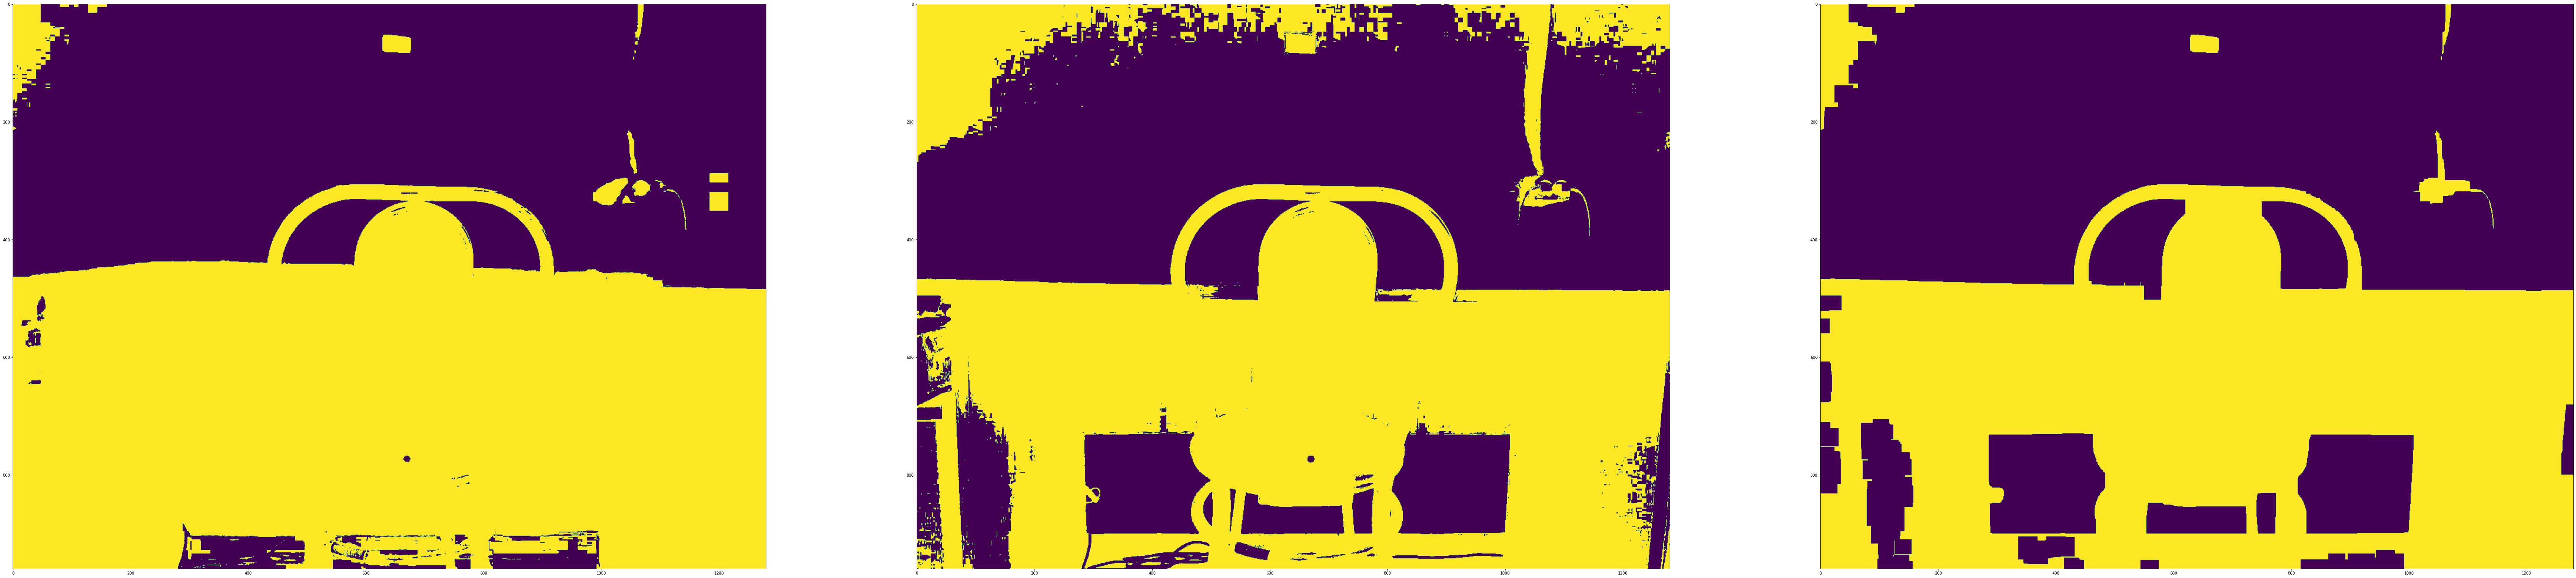

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(120, 60))

BLUE_MIN = np.array([0, 40, 0],np.uint8)
BLUE_MAX = np.array([180, 255, 255],np.uint8)

hsv_img = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)

frame_threshed = cv2.inRange(hsv_img, BLUE_MIN, BLUE_MAX)

gray_img = rgb2gray(img)
local = (gray_img < threshold_local(gray_img, 501, method='mean'))

res = []

for i in range(len(frame_threshed)):
    res.append([])
    for j in range(len(frame_threshed[i])):
        if (frame_threshed[i][j] == 255) and local[i][j]:
            res[i].append(True)
        else:
            res[i].append(False)
res = binary_closing(np.array(res), selem=np.ones((25, 25)))

ax[0].imshow(frame_threshed)
ax[1].imshow(local)
ax[2].imshow(res)

Т.к. стул сложной формы, в общем случае невозможно точно определить высоту. Однако, обычно, высота спинки стула примерно в 2 - 1.5 раза меньше высоты всего стула(в данном случае 1.8).

In [6]:
chaire_height = 0

if weidth > height:
    for j in range(point_y, 0, -1):
        if not res[j][point_x]:
            break
    
    top = j + 1
    for j in range(top, len(res)):
        if not res[j][point_x]:
            break
    bot = j - 1
    chaire_height = (bot - top) * 1.8
    
    print(chaire_height)
else:
    for i in range(point_x, 0, -1):
        if not res[point_y][i]:
            top = i
            break
    top = i + 1
    
    for i in range(top, len(res[0])):
        if not res[point_y][i]:
            bot = i
            break
    bot = i - 1    
    chaire_weidth = (bot - top) * 1.8

    print(chaire_weidth)

977.4


Для нахождения ширины стула воспользуемся тем, что самое широкое место сутла - душки по краям, почти сверху, стула. Таким образом, для нахождения ширины стула лучше всего использовать то, он симметричен, метка находится посередине стула, а значит, что нужно найти лишь душку с одной стороны.

In [7]:
if weidth > height:
    place_y = top + 100
    
    for i in range(point_x, 0, -1):
        if not res[place_y][i]:
            break
    x_tmp = i
    
    for i in range(x_tmp, 0, -1):
        if res[place_y][i]:
            break
    
    left = i
    chaire_weidth = (point_x - left) * 2
    
    print(chaire_weidth)
else:
    place_x = top + 100
    
    for j in range(point_y, 0, -1):
        if not res[j][place_x]:
            break
    
    y_tmp = j
    
    for j in range(y_tmp, 0, -1):
        if res[j][place_x]:
            break
    
    left = j
    chaire_height = (point_y - left) * 2

    print(chaire_height)

434


Таким образом, мы нашли размеры стола и стула. Далее используя соотношения размеров меток, найденные ранее, найдем истинный размеры стула. И используя эти размеры определяем пролезетт ли стул под стол или нет. Также разобран случай, при котором стул никогда не пролезет под стол(все его размеры больше, чем у стола).

In [8]:
chaire_weidth /= attitude
chaire_height /= attitude

answer = 3

if chaire_height <= table_height and chaire_weidth <= table_weight:
    answer = 1
    
if chaire_height >= table_height and chaire_weidth >= table_weight:
    answer = 2

if table_weight < chaire_height:
    answer = 2

Далее определим пролезет ли стул под стол в случае, если его повернуть, и если да, то на сколько ег онужн оповернуть.

In [9]:
if answer == 3:
    a = 2*atan((chaire_weidth + sqrt(chaire_height**2 + chaire_weidth**2\
                                 - table_height**2))/(chaire_height + table_height))
    
    angle = a * 180 / pi
    if angle < 0 or angle > 93: # 93 из за больших погрешностей в вычислении 
        print("Angle not found")
    else:
        print(int(angle))
else:
    if answer == 1:
        print("Стул пролазит под стол")
    if answer == 2:
        print("Стул не может пролезть под стол")


87
